In [2]:
#importing libraries
import pandas as pd
import numpy as np
import random
import json
from epiweeks import Week, Year
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster, GeoJSON
from shapely.geometry import shape, Point, MultiLineString
import networkx as nx

%matplotlib inline

In [2]:
df_hospitals = pd.read_csv('../dados/HospitaisCuritiba.csv', sep=';')
df_linhas = pd.read_csv('../dados/linhas.csv', sep=';')
df_atendimentos = pd.read_csv('../dados/AtendimentosCovid.csv', sep=';')
df_bairros = pd.read_csv('../dados/bairrosGeoJson.csv', sep=';')

/home/fernando/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_hospitals.head(10)

CNES          Estabelecimento Município                     Logradouro  \
0  17531               UMS ABAETE  Curitiba   RUA DELEGADO MIGUEL ZACARIAS   
1  16918               UMS ATENAS  Curitiba            RUA EMILIA ERICHSEN   
2  17523                UMS ATUBA  Curitiba                RUA RIO PELOTAS   
3  16624               UMS AURORA  Curitiba             RUA TEOFILO MANSUR   
4  17515            UMS BACACHERI  Curitiba            AVN ERASTO GAERTNER   
5  17507          UMS BARREIRINHA  Curitiba         RUA SANTA GEMA GALGANI   
6  17108               UMS CAJURU  Curitiba             RUA PEDRO BOCCHINO   
7  16888  UMS CAMPINA DO SIQUEIRA  Curitiba                 MARIO TOURINHO   
8  17124            UMS ESMERALDA  Curitiba  RUA CEL RIVADAVIA P DE MORAIS   
9  16667        UMS FANNY LINDOIA  Curitiba            RUA CONDE DOS ARCOS   

  Numero  Cep       lat       lng      requestId               bairro  
0    403  NaN -25.38004 -49.24586  4106900017531            BOA VISTA  
1     45  NaN -25.45388 -49.35444  4106900016918    CIDADE INDUSTRIAL  
2    S/N  NaN -25.39450 -49.20415  4106900017523                ATUBA  
3    500  NaN -25.49123 -49.30860  4106900016624           NOVO MUNDO  
4    797  NaN -25.40085 -49.23950  4106900017515            BACACHERI  
5    353  NaN -25.36382 -49.26298  4106900017507          BARREIRINHA  
6    750  NaN -25.45229 -49.21759  4106900017108               CAJURU  
7   1684  NaN -25.43776 -49.30771  4106900016888  CAMPINA DO SIQUEIRA  
8    431  NaN -25.50835 -49.26966  4106900017124                XAXIM  
9    295  NaN -25.47872 -49.27273  4106900016667              LINDOIA

In [5]:
markerList = []

In [6]:
for index, row in df_hospitals.iterrows():
    markerList.append(Marker(location=(row['lat'], row['lng'])))

In [7]:
# Teste plot hospitais
m = Map(center=(-25.436889, -49.271532), zoom=13)

marker_cluster = MarkerCluster(
    markers=markerList
)

m.add_layer(marker_cluster);

m

Map(center=[-25.436889, -49.271532], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [8]:
pd.set_option('max_colwidth', None) # show full width of showing cols

In [9]:
df_linhas = df_linhas[df_linhas['geojson'].apply(lambda x: len(x) > 160)]
teste_linha = df_linhas.loc[6]

In [10]:
geojsonFeature_linha = json.loads(teste_linha['geojson'])

In [11]:
# Teste plot Linhas de onibus
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

geo_json = GeoJSON(
    data=geojsonFeature_linha
)
m.add_layer(geo_json)

m

Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [12]:
teste_bairro = df_bairros.loc[6]

In [13]:
geojsonFeature_bairro = json.loads(teste_bairro['geojson'])

In [14]:
# Teste plot bairros
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

geo_json = GeoJSON(
    data=geojsonFeature_bairro
)
m.add_layer(geo_json)

m

Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [15]:
polygon = shape(geojsonFeature_bairro)

In [16]:
linhasDoBairo = []

In [17]:
for index, row in df_linhas.iterrows():
    geom = json.loads(row['geojson'])
    lines = shape(geom)
    #if polygon.touches(lines):
    if lines.intersects(polygon):
        linhasDoBairo.append(geom)

In [18]:
# Teste linhas que passam por um bairro
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

geo_json = GeoJSON(
    data=geojsonFeature_bairro
)
m.add_layer(geo_json)

for linha in linhasDoBairo:
    geo_json = GeoJSON(data=linha)
    m.add_layer(geo_json)

m

Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [19]:
# Os dados de atendimento disponibilizados pela prefeitura foram filtrados em apenas 3 tipos de diagnosticos
# Covid confirmada, covid suspeita e sindrome respiratoria aguda, abaixo a descrição completa desses diagnosticos
# Para essa pesquisa serão filtrados apenas os diagnosticos de covid confirmados ou suspeitos
# Representados respectivamente pelos CID 'U071' e 'U072'

# DIAGNOSTICO CLINICO OU EPIDEMIOLOGICO COVID-19, QUANDO A CONFIRMACAO LABORATORIAL E INCONCLUSIVA OU NAO ESTA DISPONIVEL
# DIAGNOSTICO DE COVID-19 CONFIRMADO POR EXAMES LABORATORIAIS
# SINDROME RESPIRATORIA AGUDA GRAVE [SEVERE ACUTE RESPIRATORY SYNDROME) [SARS], NAO ESPECIFICADA

#teste = df_atendimentos[df_atendimentos['Código do CID'] == 'U071'].drop_duplicates()
teste = df_atendimentos[(df_atendimentos['Código do CID'] == 'U071') | (df_atendimentos['Código do CID'] == 'U072')].drop_duplicates()

In [20]:
teste['Data do Atendimento'] = pd.to_datetime(teste['Data do Atendimento'],format='%d/%m/%Y %H:%M:%S')

In [21]:
teste['Data de Nascimento'] = pd.to_datetime(teste['Data de Nascimento'],format='%d/%m/%Y %H:%M:%S')

In [22]:
pd.set_option("max_columns", None) # show all cols
teste.describe(include=['O'])

Sexo Tipo de Unidade  Descricao da Unidade  \
count   209259          209259                209259   
unique       2               3                   122   
top          F          BASICO  UMS OUVIDOR PARDINHO   
freq    128869          197401                  7824   

                  Descricao do Procedimento  Código do CBO  \
count                                209259         209259   
unique                                   25             25   
top     CONSULTA MEDICA EM ATENCAO PRIMARIA         225170   
freq                                 193540          71905   

                                Descricao do CBO Código do CID  \
count                                     209259        209259   
unique                                        14             2   
top     MEDICO DA ESTRATEGIA DE SAUDE DA FAMILIA          U072   
freq                                       88089        191781   

                                                                                                               Descricao do CID  \
count                                                                                                                    209259   
unique                                                                                                                        2   
top     DIAGNOSTICO CLINICO OU EPIDEMIOLOGICO COVID-19, QUANDO A CONFIRMACAO LABORATORIAL E INCONCLUSIVA OU NAO ESTA DISPONIVEL   
freq                                                                                                                     191781   

       Solicitacao de Exames Qtde Prescrita Farmácia Curitibana  \
count                 209259                             209259   
unique                     2                               2194   
top                      Nao                                  0   
freq                  112643                              35028   

       Qtde de Medicamento Nao Padronizado  \
count                               209259   
unique                                 524   
top                                      0   
freq                                164346   

       Encaminhamento para Atendimento Especialista  \
count                                        209259   
unique                                            2   
top                                             Nao   
freq                                         207284   

                   Área de Atuacao Desencadeou Internamento  \
count                          731                   209259   
unique                          38                        2   
top     OTORRINOLARINGOLOGIA GERAL                      Nao   
freq                           127                   207945   

       Data do Internamento Estabelecimento Solicitante  \
count                  1236                        1314   
unique                  915                           9   
top     06/08/2020 04:22:00                  UPA CAJURU   
freq                      5                         374   

             Estabelecimento Destino CID do Internamento  \
count                           1314                1314   
unique                            18                  47   
top     HOSPITAL DO IDOSO ZILDA ARNS                U072   
freq                             614                 884   

       Tratamento no Domicílio Abastecimento Energia Elétrica  \
count                   179294        179321           209259   
unique                       4             5                2   
top             SEM TRATAMENTO  REDE PÚBLICA              Sim   
freq                     95504        176008           194609   

                        Tipo de Habitacao Destino Lixo        Fezes/Urina  \
count                              179331       179327             179327   
unique                                  8            4                  6   
top     TIJOLO/ALVENARIA COM REVESTIMENTO     COLETADO  SISTEMA DE ESGOTO   
freq                               159083

In [23]:
teste['idade'] = teste['Data de Nascimento'].apply(lambda x: 2021 - x.year)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ONIBUS'),
  Text(1, 0, 'ONIBUS,CARRO'),
  Text(2, 0, 'CARRO'),
  Text(3, 0, 'OUTROS'),
  Text(4, 0, 'OUTROS,ONIBUS,CARRO'),
  Text(5, 0, 'OUTROS,ONIBUS'),
  Text(6, 0, 'ONIBUS,CAMINHAO'),
  Text(7, 0, 'ONIBUS,METRO,CARRO'),
  Text(8, 0, 'ONIBUS,CARRO,CAMINHAO'),
  Text(9, 0, 'OUTROS,CARRO')])

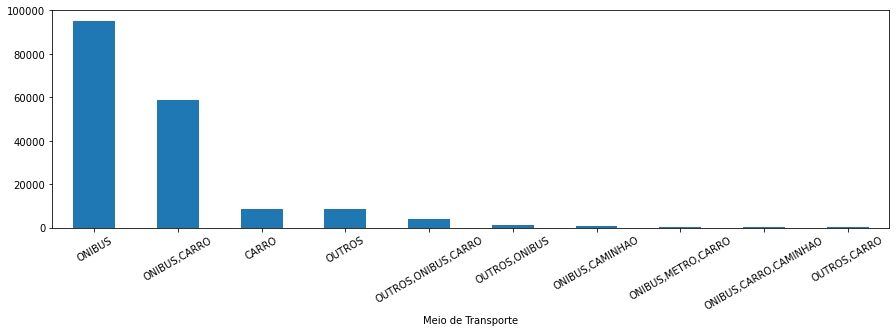

In [24]:
# 29940 registros não possuem esse dado de transporte
plt.figure(figsize=(15,4))
df_transporte = teste.groupby('Meio de Transporte').size().sort_values(ascending=False).head(10)
df_transporte.plot.bar()
plt.xticks(rotation=30)

In [25]:
teste['mes/ano atendimento'] = teste['Data do Atendimento'].apply(lambda x: str((x.year*100) + x.month))

In [26]:
evolucaoMeses = teste.groupby(['mes/ano atendimento'])['mes/ano atendimento'].count().reset_index(name='counts')

In [27]:
teste['semana'] = teste['Data do Atendimento'].apply(lambda x: Week.fromdate(x).cdcformat())
evolucaoSemanas = teste.groupby(['semana'])['semana'].count().reset_index(name='counts')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

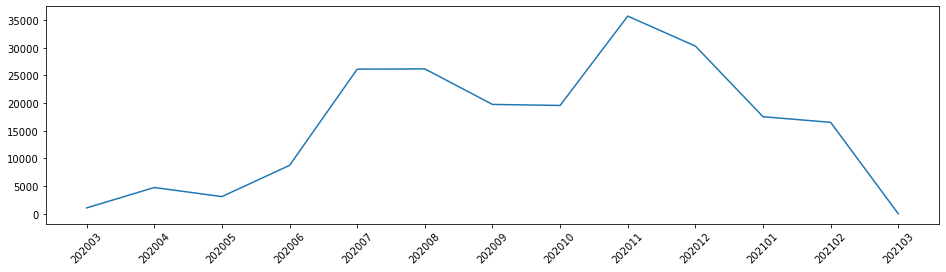

In [28]:
plt.figure(figsize=(16,4))
plt.plot(evolucaoMeses['mes/ano atendimento'],evolucaoMeses['counts'])
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

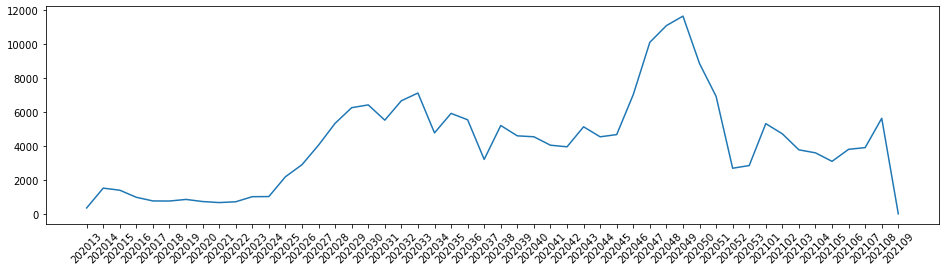

In [29]:
plt.figure(figsize=(16,4))
plt.plot(evolucaoSemanas['semana'],evolucaoSemanas['counts'])
plt.xticks(rotation=45)

In [30]:
# quantidade de entidades que serao analisadas
qt = 10

In [31]:
grupoBairros = teste.groupby(['Bairro']).size().sort_values(ascending=False).reset_index().rename(columns={0:'count'}).head(qt)
grupoBairros

Bairro  count
0  CIDADE INDUSTRIAL  29174
1      SITIO CERCADO  16562
2             CAJURU  13575
3            UBERABA   9545
4          BOQUEIRAO   8337
5     ALTO BOQUEIRAO   8200
6        BAIRRO ALTO   7690
7          TATUQUARA   7444
8        PINHEIRINHO   7251
9      SANTA CANDIDA   6380

In [32]:
evolucaoBairrosMes = teste.groupby(['Bairro','mes/ano atendimento']).size().reset_index().rename(columns={0:'count'})
evolucaoBairrosSemanas = teste.groupby(['Bairro','semana']).size().reset_index().rename(columns={0:'count'})

df_evolucaoBairrosMes = evolucaoBairrosMes[evolucaoBairrosMes['Bairro'].isin(grupoBairros['Bairro'].values)]
df_evolucaoBairrosSemanas = evolucaoBairrosSemanas[evolucaoBairrosSemanas['Bairro'].isin(grupoBairros['Bairro'].values)]

In [33]:
df_grafico = grupoBairros.head(qt)
x_mes = df_evolucaoBairrosMes['mes/ano atendimento'].unique()
x_semanas = df_evolucaoBairrosSemanas['semana'].unique()

In [34]:
#retira a ultima semana pois nem todos os bairros tem essa semana nos dados 
x_semanas = np.delete(x_semanas, -1)

In [35]:
df_evolucaoBairrosSemanas.drop(df_evolucaoBairrosSemanas[df_evolucaoBairrosSemanas['semana'] == '202109'].index,inplace = True)

/home/fernando/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
eixo_y_mes = []
eixo_y_semanas = []
df_grafico.loc[0]
for i in range(qt):
    bairro_nome = df_grafico.iloc[i]['Bairro']
    eixo_y_mes.append({'bairro':bairro_nome, 'count':df_evolucaoBairrosMes.loc[df_evolucaoBairrosMes['Bairro'] == bairro_nome]['count']})
    eixo_y_semanas.append({'bairro':bairro_nome, 'count':df_evolucaoBairrosSemanas.loc[df_evolucaoBairrosSemanas['Bairro'] == bairro_nome]['count']})

In [37]:
x_mes = ['202003','202004','202005','202006','202007','202008','202009','202010','202011','202012','202101','202102']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

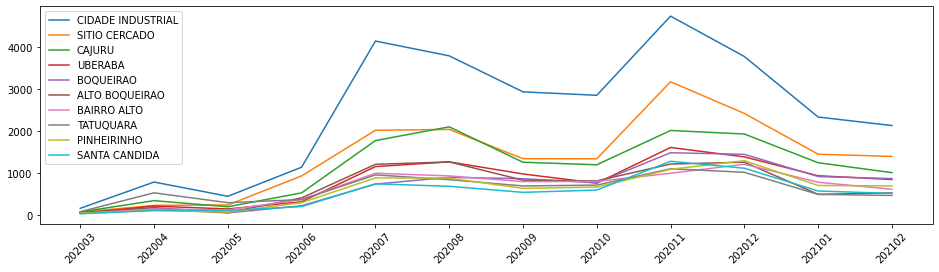

In [38]:
plt.figure(figsize=(16,4))
for i in range(qt):
    plt.plot(x_mes, eixo_y_mes[i]['count'], label=eixo_y_mes[i]['bairro'])
    
plt.legend()
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

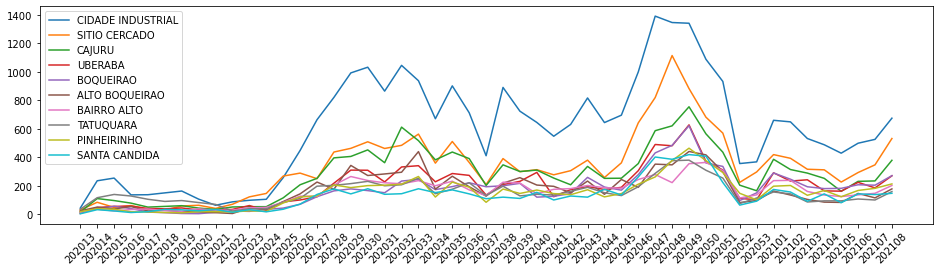

In [39]:
plt.figure(figsize=(16,4))
for i in range(qt):
    plt.plot(x_semanas, eixo_y_semanas[i]['count'], label=eixo_y_semanas[i]['bairro'])
    
plt.legend()
plt.xticks(rotation=45)

In [40]:
# 
df_bairros['nome'].replace('CIDADE INDUSTRIAL DE CURITIBA','CIDADE INDUSTRIAL',inplace = True)
df_bairros['nome'].replace('SÍTIO CERCADO','SITIO CERCADO',inplace = True)
df_bairros['nome'].replace('BOQUEIRÃO','BOQUEIRAO',inplace = True)
df_bairros['nome'].replace('ALTO BOQUEIRÃO','ALTO BOQUEIRAO',inplace = True)
df_bairros['nome'].replace('SANTA CÂNDIDA','SANTA CANDIDA',inplace = True)

In [41]:
top_bairros = df_bairros[df_bairros['nome'].isin(grupoBairros['Bairro'].values)]
hospital_top_bairros = df_hospitals[df_hospitals['bairro'].isin(grupoBairros['Bairro'].values)]

In [42]:
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

for index, bairro in top_bairros.iterrows():
    geojsonFeature_bairro = json.loads(bairro['geojson'])
    geo_json = GeoJSON(
        data=geojsonFeature_bairro
    )
    m.add_layer(geo_json)

top_hopitais =[]
for index, hospital in hospital_top_bairros.iterrows():
    top_hopitais.append(Marker(location=(hospital['lat'], hospital['lng'])))
    
marker_cluster = MarkerCluster(
    markers=top_hopitais
)

m.add_layer(marker_cluster);

m


Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [43]:
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

for index, bairro in top_bairros.iterrows():
    geojsonFeature_bairro = json.loads(bairro['geojson'])
    polygon = shape(geojsonFeature_bairro)
    linhasDoBairo = []
    
    for index, row in df_linhas.iterrows():
        geom = json.loads(row['geojson'])
        lines = shape(geom)
        #if polygon.touches(lines):
        if lines.intersects(polygon):
            linhasDoBairo.append(geom)   
    
    for linha in linhasDoBairo:
        geo_json = GeoJSON(data=linha)
        m.add_layer(geo_json)
    
    geo_json = GeoJSON(
        data=geojsonFeature_bairro
    )
    m.add_layer(geo_json)

m

Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [44]:
bairros_linhas = {}

for index, bairro in df_bairros.iterrows():
    geojsonFeature_bairro = json.loads(bairro['geojson'])
    polygon = shape(geojsonFeature_bairro)
    linhasDoBairo = []
    
    for index, row in df_linhas.iterrows():
        geom = json.loads(row['geojson'])
        lines = shape(geom)
        if lines.intersects(polygon):            
            bairros_linhas[bairro['nome']] = bairros_linhas.get(bairro['nome'], 0) + 1

In [45]:
sorted_bairros_linhas = {}
sorted_keys = sorted(bairros_linhas, key=bairros_linhas.get, reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_bairros_linhas[w] = bairros_linhas[w]

<AxesSubplot:xlabel='bairro'>

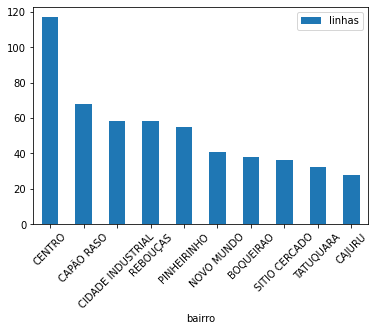

In [46]:
df_sorted_bairros_linhas = pd.DataFrame(sorted_bairros_linhas.items(), columns=['bairro', 'linhas'])
df_sorted_bairros_linhas.head(10).plot.bar(x='bairro', y='linhas', rot=45)

In [47]:
top_bairros_linhas = df_sorted_bairros_linhas[df_sorted_bairros_linhas['bairro'].isin(grupoBairros['Bairro'].values)]

<AxesSubplot:xlabel='bairro'>

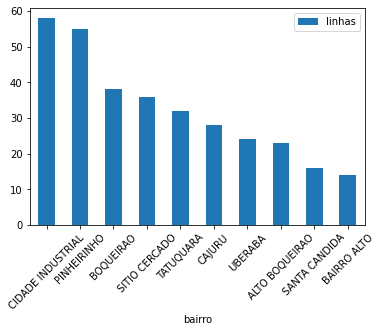

In [48]:
top_bairros_linhas.plot.bar(x='bairro', y='linhas', rot=45)

In [4]:
G = nx.read_gpickle('../dados/multidigraph.gpickle')

NetworkXError: Node 160160 has no position.

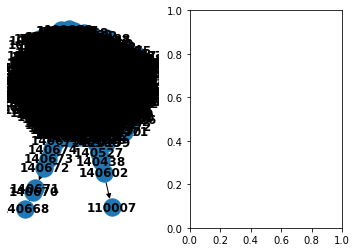

In [5]:
#G = nx.petersen_graph()
plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)

nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [8]:
#nx.get_node_attributes(G, 'regional')#, para os nós
nx.get_edge_attributes(G,'dist')#, para as arestas

{(160160, 160161, 8373): 246.2083790890884,
 (160160, 160161, 929): 246.2083790890884,
 (160160, 160161, 754): 246.2083790890884,
 (160160, 160161, 1781): 246.2083790890884,
 (160161, 160164, 8373): 274.73584686356156,
 (160161, 160164, 929): 274.73584686356156,
 (160161, 160164, 754): 274.73584686356156,
 (160161, 160164, 1781): 274.73584686356156,
 (160164, 160166, 8373): 286.02616595882495,
 (160164, 160166, 929): 286.02616595882495,
 (160164, 160166, 754): 286.02616595882495,
 (160164, 160166, 1781): 286.02616595882495,
 (160166, 160168, 8373): 122.78321854303485,
 (160166, 160168, 929): 122.78321854303485,
 (160166, 160168, 754): 122.78321854303485,
 (160166, 160168, 1781): 122.78321854303485,
 (160168, 160169, 8373): 472.1828280818474,
 (160168, 160169, 929): 472.1828280818474,
 (160168, 160169, 754): 472.1828280818474,
 (160168, 160169, 1781): 472.1828280818474,
 (160169, 160172, 8373): 244.26634261652717,
 (160169, 160172, 929): 244.26634261652717,
 (160169, 160172, 754): 244.2

In [8]:
list(G.nodes)

[160160,
 160161,
 160164,
 160166,
 160168,
 160169,
 160172,
 160173,
 160157,
 160155,
 160015,
 160014,
 160012,
 160740,
 160203,
 160004,
 160002,
 150105,
 150103,
 150128,
 150130,
 150132,
 160021,
 106019,
 160023,
 160025,
 160027,
 160029,
 160031,
 160034,
 160035,
 160037,
 160244,
 150751,
 150330,
 150332,
 105736,
 170983,
 170123,
 170052,
 160245,
 160038,
 160036,
 160033,
 160032,
 160030,
 160028,
 160026,
 160024,
 106109,
 160022,
 150131,
 150129,
 150127,
 150102,
 150104,
 160001,
 160003,
 160202,
 160741,
 160011,
 160013,
 160433,
 160156,
 160158,
 160174,
 160171,
 160170,
 160167,
 160165,
 160163,
 160162,
 104804,
 106101,
 108132,
 108130,
 108128,
 108126,
 108124,
 105702,
 108064,
 108062,
 108060,
 108058,
 105701,
 105502,
 108088,
 108090,
 108092,
 104902,
 108094,
 108096,
 104304,
 108111,
 108109,
 108107,
 108105,
 108103,
 108101,
 108099,
 108097,
 108056,
 108053,
 108051,
 108122,
 108120,
 108118,
 108116,
 108114,
 108212,
 108083,
 

In [21]:
G.edges.data()

OutMultiEdgeDataView([(160160, 160161, {'dist': 246.2083790890884, 'dist_norm': 0, 'seq': 1}), (160160, 160161, {'dist': 246.2083790890884, 'dist_norm': 0, 'seq': 1}), (160160, 160161, {'dist': 246.2083790890884, 'dist_norm': 0, 'seq': 1}), (160160, 160161, {'dist': 246.2083790890884, 'dist_norm': 0, 'seq': 1}), (160161, 160164, {'dist': 274.73584686356156, 'dist_norm': 0, 'seq': 2}), (160161, 160164, {'dist': 274.73584686356156, 'dist_norm': 0, 'seq': 2}), (160161, 160164, {'dist': 274.73584686356156, 'dist_norm': 0, 'seq': 2}), (160161, 160164, {'dist': 274.73584686356156, 'dist_norm': 0, 'seq': 2}), (160164, 160166, {'dist': 286.02616595882495, 'dist_norm': 0, 'seq': 3}), (160164, 160166, {'dist': 286.02616595882495, 'dist_norm': 0, 'seq': 3}), (160164, 160166, {'dist': 286.02616595882495, 'dist_norm': 0, 'seq': 3}), (160164, 160166, {'dist': 286.02616595882495, 'dist_norm': 0, 'seq': 3}), (160166, 160168, {'dist': 122.78321854303485, 'dist_norm': 0, 'seq': 4}), (160166, 160168, {'d

In [19]:
#160203, 160154, 9074): 107.58105909931227,
G[160203][160154]

AtlasView({9074: {'dist': 107.58105909931227, 'dist_norm': 0, 'seq': 45}, 752: {'dist': 107.58105909931227, 'dist_norm': 0, 'seq': 16}, 754: {'dist': 107.58105909931227, 'dist_norm': 0, 'seq': 15}})